In [182]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

## Understanding what derivative is?

In [34]:
def f(x):
    return 3 *x**2 - 4*x + 5 

In [35]:
f(3.0)

20.0

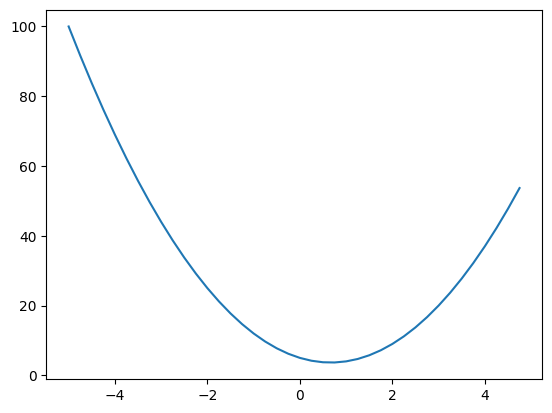

In [36]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [37]:
h = 0.0000000001
x = 2/3
(f(x+h) - f(x)) / h

0.0

In [38]:
#lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [39]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c

a += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1)/h)

d1: 4.0
d2: 3.9999699999999994
slope: -3.000000000064062


In [40]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c

b += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1)/h)

d1: 4.0
d2: 4.00002
slope: 2.0000000000131024


In [41]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c

c += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1)/h)

d1: 4.0
d2: 4.00001
slope: 0.9999999999621422


## Micrograd

In [294]:
class Value:

    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op #we want to know which operation created this
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self, other),'+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out

    def __sub__(self, other): #self + (-other)
        return self + (-1 * other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
            
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other ** - 1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [43]:
d._op

'+'

In [8]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad,), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


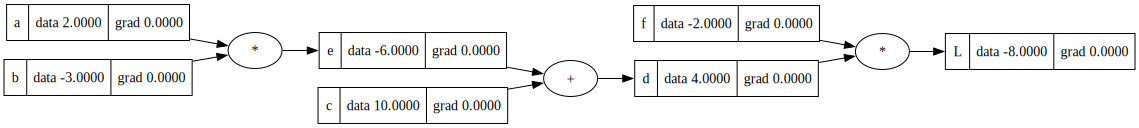

In [45]:
draw_dot(L)

## Backpropagation

**Backpropogation** : Recursive application of chain rules backwards through computational graph (finding derivative)

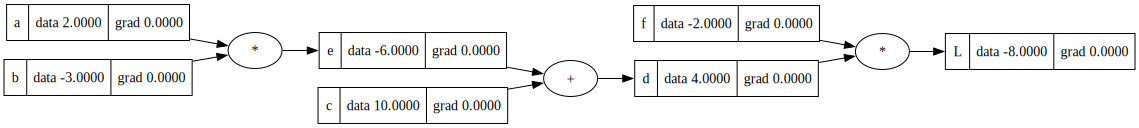

In [46]:
draw_dot(L)

In [47]:
L.grad = 1.0 # manual back propogation

In [55]:
#therefore:
f.grad = 4.0
d.grad = -2

In [56]:
#therefore:
c.grad = -2.0
e.grad = -2.0

In [58]:
#therefore:
a.grad = 6.0
b.grad = -4.0

In [51]:
#use this function to check the derivatives:
def lol():
    h  = 0.001
    a = Value(2.0, label = 'a')
    b = Value(-3.0,label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0,label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data + h

    print((L2 - L1) / h)

lol()

1.000000000000334


In [59]:
#nudge out input to increase L
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-6.586368000000001


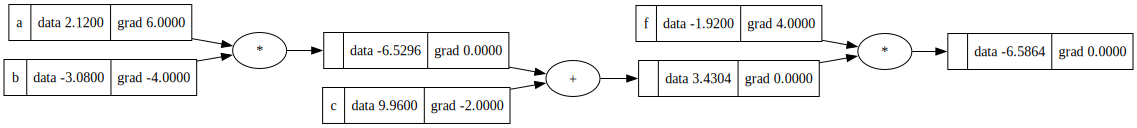

In [60]:
draw_dot(L)

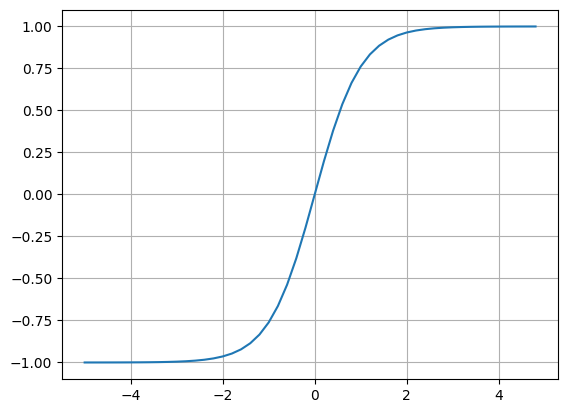

In [61]:
plt.plot(np.arange(-5, 5,0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

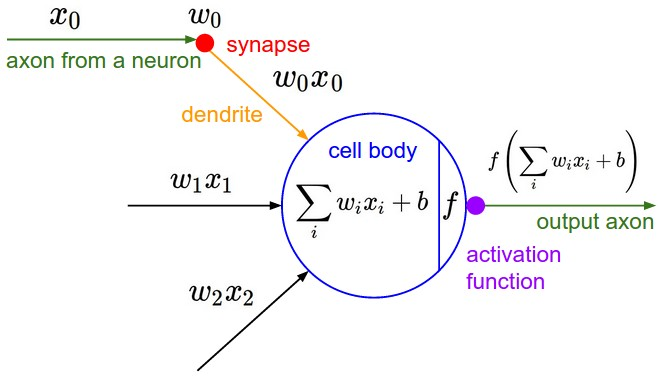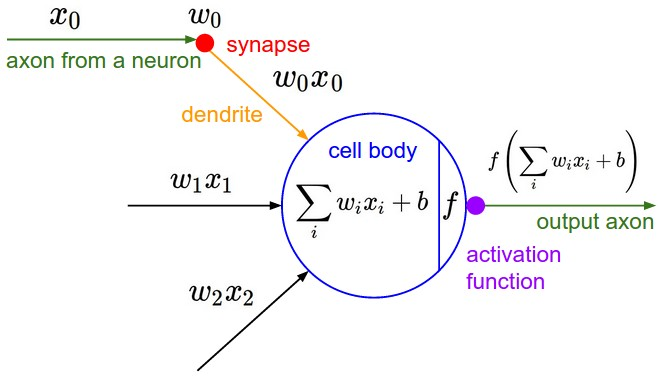

In [10]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1 ; x1w1.label = 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

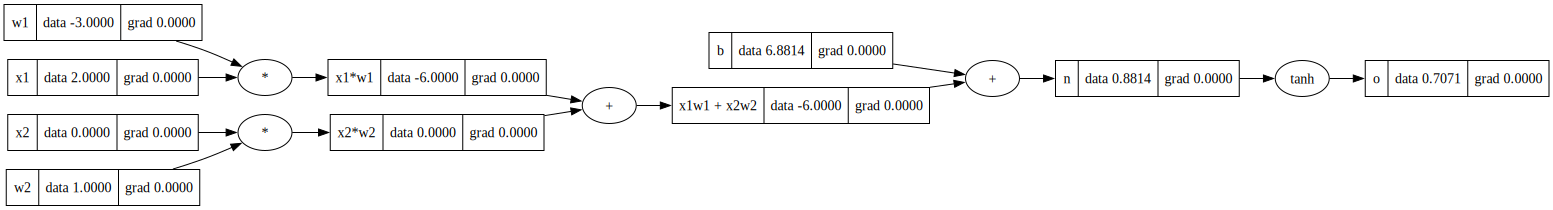

In [77]:
draw_dot(o)

In [14]:
o.grad = 1.0

In [15]:
# o = tanh(n)
# do / dn = 1 - o ** 2

In [16]:
1 - o.data ** 2 #do / dn

0.4999999999999999

In [17]:
n.grad = 1 - o.data**2

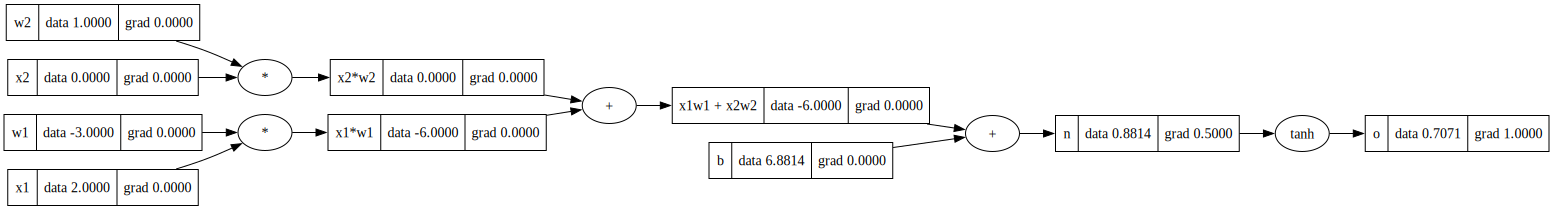

In [18]:
draw_dot(o)

In [19]:
x1w1x2w2.grad = 0.5

In [20]:
b.grad = 0.5

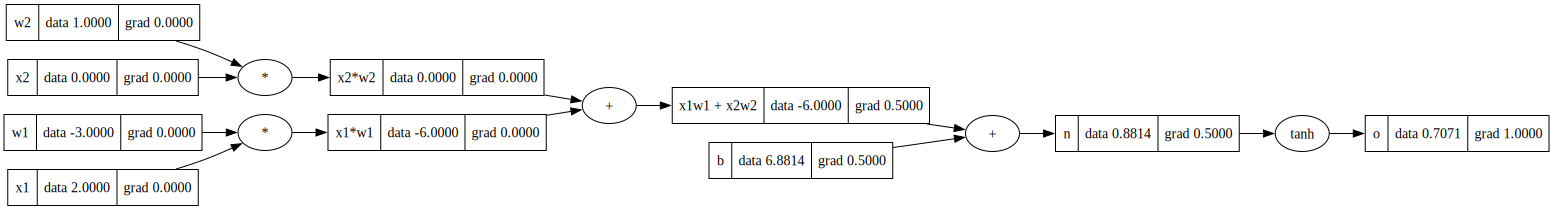

In [21]:
draw_dot(o)

In [22]:
x1w1.grad = 0.5

In [23]:
x2w2.grad = 0.5

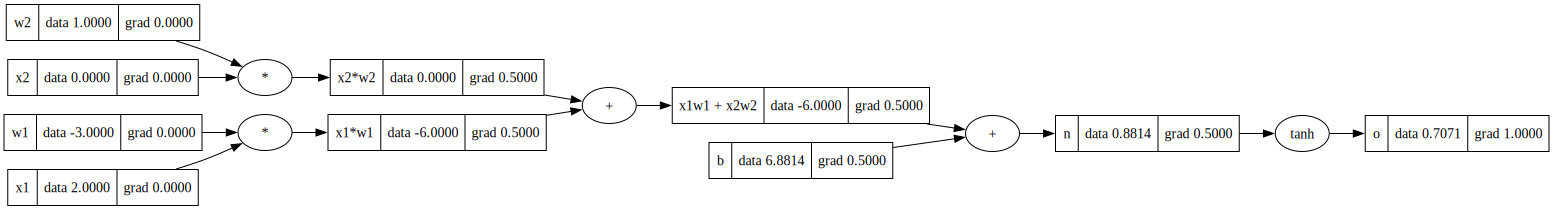

In [24]:
draw_dot(o)

In [25]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

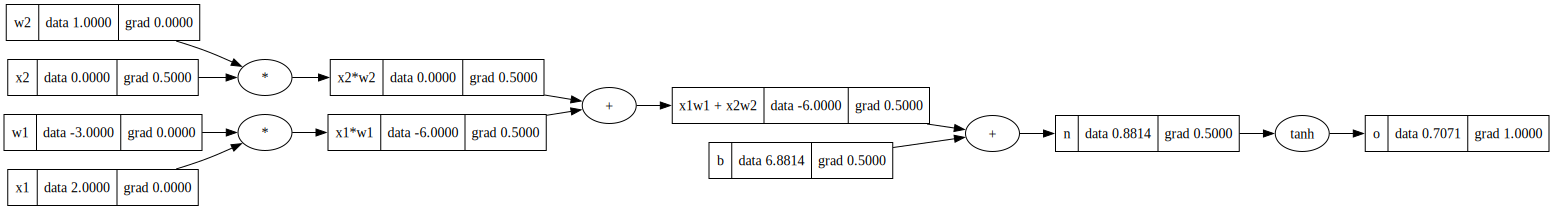

In [26]:
draw_dot(o)

In [27]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

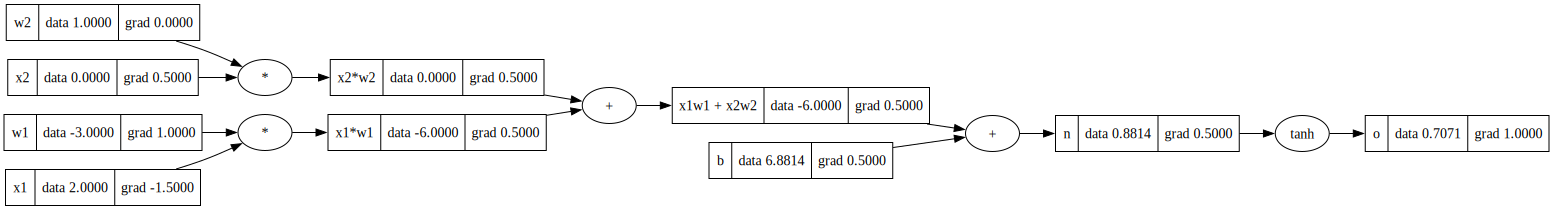

In [28]:
draw_dot(o)

## Added _backward() function

In [35]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1 ; x1w1.label = 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

In [37]:
o.grad = 1.0

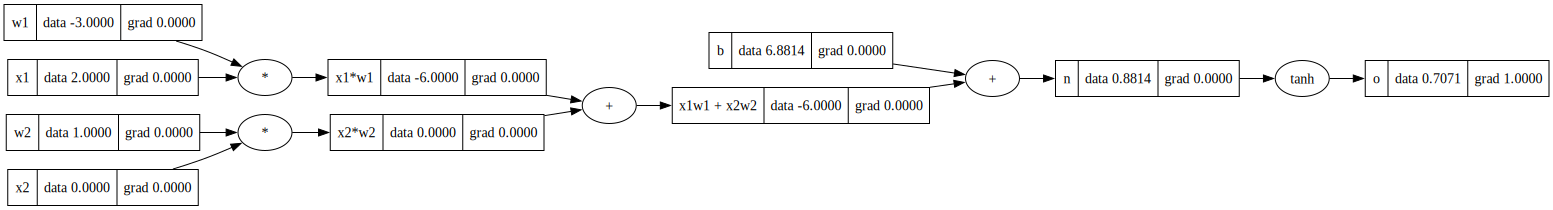

In [38]:
draw_dot(o)

In [44]:
o._backward() #should set n.grad = 0.5

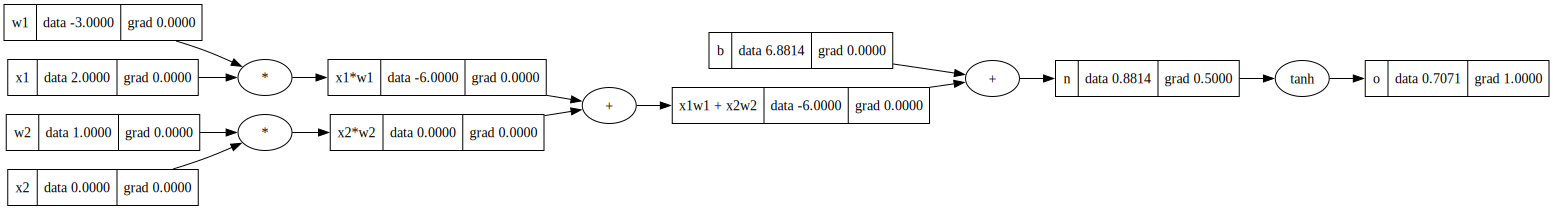

In [45]:
draw_dot(o)

In [46]:
n._backward()

In [47]:
b._backward()

In [48]:
x1w1x2w2._backward()

In [49]:
x2w2._backward()
x1w1._backward()

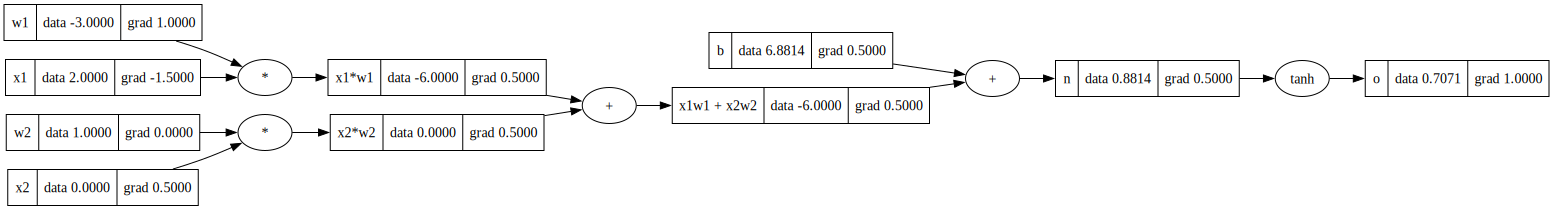

In [50]:
draw_dot(o)

In [51]:
#now we have to remove the ._backward() for all node, just call it for o._backward()

In [79]:
#topo sort so all the nodes are pointed from LEFT TO RIGHT
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data = 6.881373587019543),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = 0.0),
 Value(data = 2.0),
 Value(data = -3.0),
 Value(data = -6.0),
 Value(data = -6.0),
 Value(data = 0.8813735870195432),
 Value(data = 0.7071067811865476)]

In [62]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1 ; x1w1.label = 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

In [63]:
o.grad = 1.0

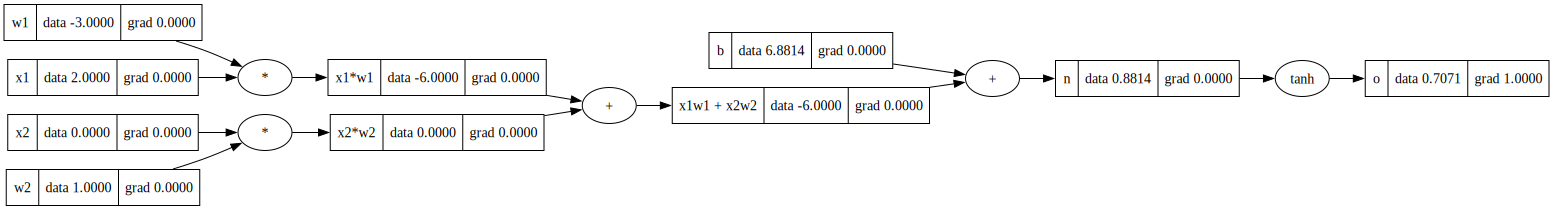

In [64]:
draw_dot(o)

In [80]:
for node in reversed(topo):
    node._backward()

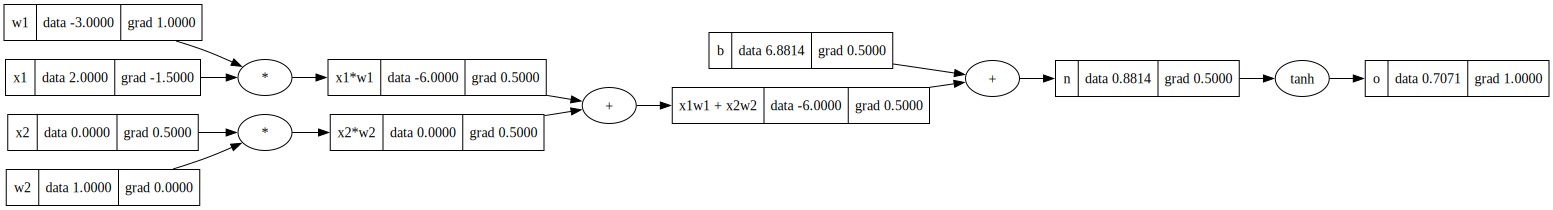

In [81]:
draw_dot(o)

## Implemented backward() in Value class

In [87]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1 ; x1w1.label = 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

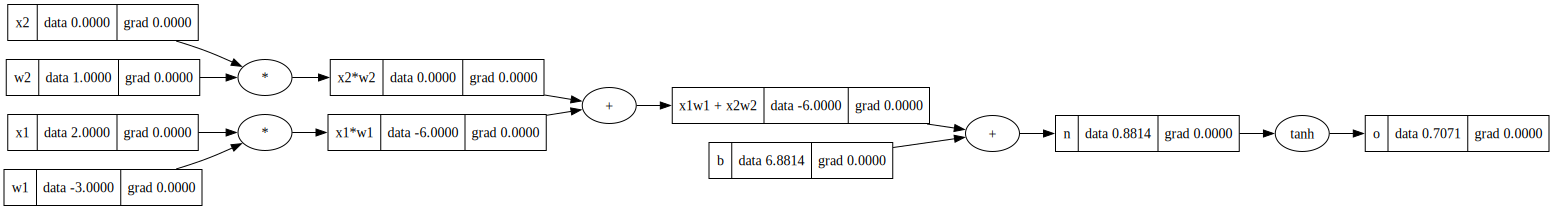

In [88]:
draw_dot(o)

In [89]:
o.backward()

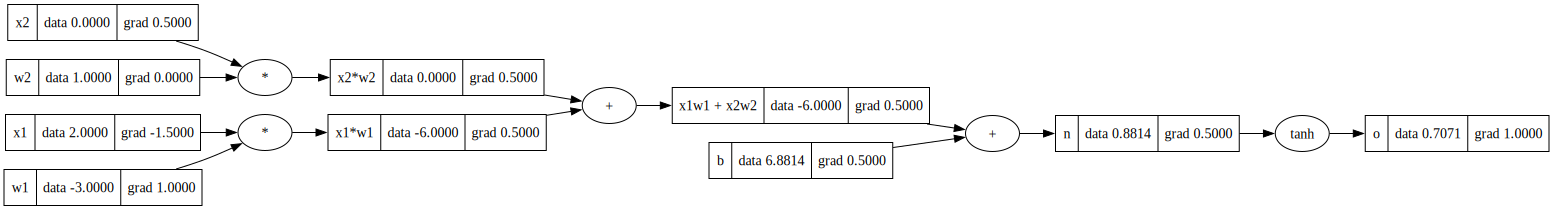

In [90]:
draw_dot(o)

## Fixing a backprop bug when one node is used multiple times

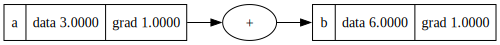

In [96]:
a = Value(3.0, label = 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

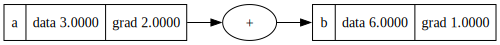

In [98]:
a = Value(3.0, label = 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

## Breaking up a tanh, exercising with more operations

In [148]:
a = Value(2.0)
a + 1

Value(data = 3.0)

In [149]:
a = Value(2.0)
a * 10

Value(data = 20.0)

In [150]:
2 * a

Value(data = 4.0)

In [151]:
a.exp()

Value(data = 7.38905609893065)

In [152]:
b = Value(4.0)
a / b # a * (1/b) , a * (b ** -1)

Value(data = 0.5)

In [153]:
a - b

Value(data = -2.0)

In [156]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1 ; x1w1.label = 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

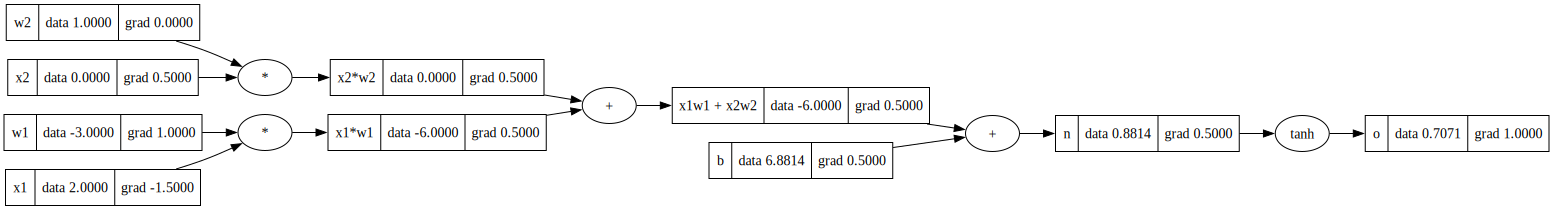

In [157]:
draw_dot(o)

In [158]:
#breakup the tanh

In [162]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1 ; x1w1.label = 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#-----------
e = (2*n).exp()
o = (e - 1) /(e + 1) ; o.label = 'o'
#-----------
o.backward()

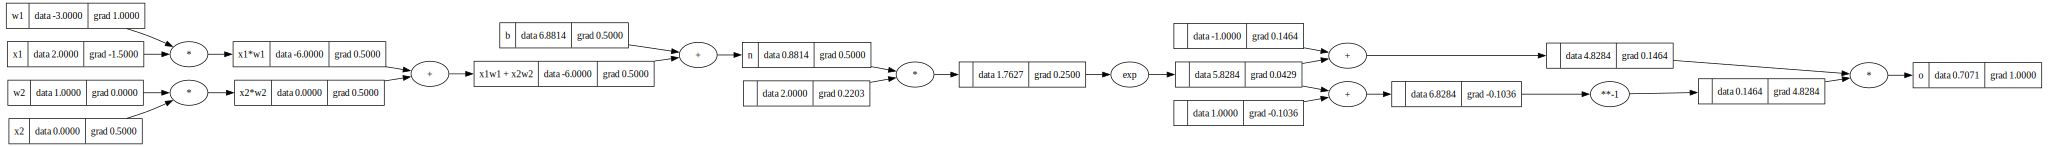

In [163]:
draw_dot(o)

## Doing above stuffs in pytorch

In [164]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1 * w1 + x2 * w2 + b

o = torch.tanh(n)

print(o.data.item())

o.backward()


print('-----')
print('w1', w1.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())
print('x2', x2.grad.item())

In [172]:
torch.Tensor([[1,2,3], [4,5,6]]).double().dtype

torch.float64

In [177]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

## Building out a neural net library (Multi-layer perceptron) in micrograd

In [318]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x): #n(x) -> calling
        # w * x + b 
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
        
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for later in self.layers for p in later.parameters()]



In [543]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data = 0.2898984271509265)

In [350]:
n.parameters()

[Value(data = 0.7870963788256882),
 Value(data = 0.22488501180672185),
 Value(data = -0.3774216026116142),
 Value(data = -0.14740618998851535),
 Value(data = -0.367233465085269),
 Value(data = -0.5139425094686928),
 Value(data = 0.5628980101842108),
 Value(data = -0.8224458588377619),
 Value(data = -0.02145294014304754),
 Value(data = -0.6100057733254161),
 Value(data = 0.7112801600851264),
 Value(data = 0.022323089478375687),
 Value(data = 0.5599886854379678),
 Value(data = 0.6660780465880487),
 Value(data = 0.03047906322456294),
 Value(data = -0.7362474011075287),
 Value(data = -0.15353029233453636),
 Value(data = -0.486602685142606),
 Value(data = 0.8177720191994813),
 Value(data = 0.5958805947009507),
 Value(data = 0.32861337690150827),
 Value(data = -0.0395589531037411),
 Value(data = -0.7197301728147167),
 Value(data = -0.5243490588690933),
 Value(data = 0.11902054870888497),
 Value(data = -0.08795760483496484),
 Value(data = 0.8356288543070605),
 Value(data = -0.0302479662241936

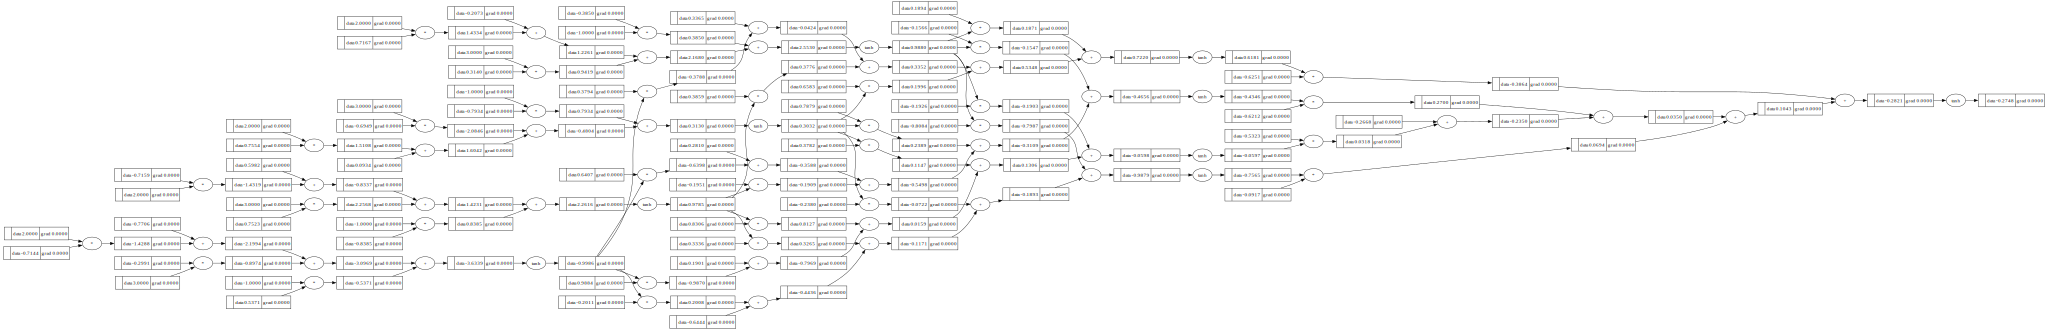

In [313]:
draw_dot(n(x))

## Creating a tiny dataset, writing the loss function

In [542]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets\

In [369]:
ypred = [n(x) for x in xs]
l = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
loss = Value(0.0)
for le in l:
    loss += le  
loss

Value(data = 1.7994887139092752)

In [370]:
loss.backward()

In [371]:
n.layers[0].neurons[0].w[0].grad

-2.2654284091022867

In [372]:
n.layers[0].neurons[0].w[0].data

0.8727862691288162

## Doing Gradient Descent optimization manually, training the network

In [525]:
for p in n.parameters():
    p.data += -0.01* p.grad

In [526]:
n.layers[0].neurons[0].w[0].data

2.8405235267715963

In [527]:
ypred = [n(x) for x in xs]
loss = Value(0.0)
for le in l:
    loss += le  
loss

Value(data = 1.4501919701473845e-08)

In [532]:
l = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

In [533]:
def myloss(l):
    loss = Value(0.0)
    for le in l:
        loss += le 
    return loss

In [529]:
loss.backward()

In [530]:
ypred

[Value(data = 0.9999922757852449),
 Value(data = -0.9999999999999822),
 Value(data = -0.9999999999999822),
 Value(data = 0.9999999977102124)]

In [512]:
n.parameters()

[Value(data = 2.7730282946012794),
 Value(data = 3.30186925518497),
 Value(data = 5.75199689176228),
 Value(data = 3.676909969577265),
 Value(data = 1.9427654291787144),
 Value(data = -0.3059050168290659),
 Value(data = 2.5776055240512643),
 Value(data = 1.5423481145518085),
 Value(data = 3.704466616397732),
 Value(data = 3.3799313425197366),
 Value(data = 0.3305331547090812),
 Value(data = 2.549129705623704),
 Value(data = 1.1549032729471849),
 Value(data = -3.3248336090538664),
 Value(data = 4.965232190776046),
 Value(data = -0.9141221319479371),
 Value(data = 2.9781347696172005),
 Value(data = -2.4851230500152637),
 Value(data = -2.511477062392019),
 Value(data = 3.7765083591526167),
 Value(data = 2.790140711664203),
 Value(data = -1.0741950173527368),
 Value(data = 2.5517548443804503),
 Value(data = -6.030006286937938),
 Value(data = -0.2709920227562444),
 Value(data = -5.517824268832475),
 Value(data = -2.003518751578657),
 Value(data = 1.88404302190754),
 Value(data = 7.941410012

In [585]:
for k in range(1000):
    
    #forward pass
    ypred = [n(x) for x in xs]
    l = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
    loss = myloss(l)

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    
    print(k+1, loss.data)
    

1 0.00025500929638190865
2 0.00025491049915904473
3 0.0002548117795459617
4 0.000254713137450088
5 0.00025461457277898354
6 0.0002545160854403626
7 0.0002544176753420841
8 0.0002543193423921622
9 0.000254221086498751
10 0.0002541229075701642
11 0.000254024805514844
12 0.0002539267802413933
13 0.0002538288316585519
14 0.0002537309596752184
15 0.00025363316420042736
16 0.0002535354451433672
17 0.0002534378024133534
18 0.0002533402359198682
19 0.000253242745572526
20 0.00025314533128109433
21 0.0002530479929554721
22 0.00025295073050570806
23 0.00025285354384200955
24 0.00025275643287469543
25 0.00025265939751425526
26 0.00025256243767131684
27 0.00025246555325663165
28 0.00025236874418111625
29 0.00025227201035581755
30 0.0002521753516919193
31 0.0002520787681007592
32 0.0002519822594938152
33 0.0002518858257826879
34 0.00025178946687913565
35 0.00025169318269505975
36 0.0002515969731424798
37 0.00025150083813357365
38 0.00025140477758065773
39 0.0002513087913961837
40 0.0002512128794927

In [586]:
ypred

[Value(data = 0.993078226938029),
 Value(data = -0.992998243864077),
 Value(data = -0.9938233122225318),
 Value(data = 0.9930034764630139)]